In [1]:
%pylab inline
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim

Populating the interactive namespace from numpy and matplotlib


In [115]:
# arr = np.random.geometric(0.2, size=10000)
# with open('mle1.npy', 'wb') as fp:
#     np.save(fp, arr - 1)

# arr = np.random.poisson(5, size=10000)
# with open('mle2.npy', 'wb') as fp:
#     np.save(fp, arr)
    
def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

## Recap from lecture

Recall that even after assuming the general shape of a distribution, we still need to estimate the distribution's parameters to model the data provided well.

Recall that we can measure how well a particular configuration of parameters fits a distribution by using its likelihood function. Also recall that we also observed that by maximising the likelihood wrt to the parameters we can fit the distribution.

As we saw in class,  likelihood functions are difficult to optmise in their original form, so we derive the negative log-likelihood (NLL) and then minimise wrt to the parameters to fit the distribution. Once we have the problem as an unconstrained minimisation problem, we can solve it using gradient descent.

### Example for Geometric Distribution

Suppose that we assume that our dataset $D = \{x_1, x_2, \ldots, x_n\}$ follow a Geometric Distribtion. For example, each data point (sclar ) represents the number of times we had to flip a coin before it came up heads. The Geometric Distribution has a parameter $p$ - the probability of success - in this case flipping and coming with heads - for a particular trial. We want to estimate the value of $p$ from our data. We first must derive the NLL for the geometric distribution. This is as follows:

$$\mathcal{L}(D;p) = \prod_{i=1}^{n}(1 - p)^{x_i}p$$
$$\log\mathcal{L}(D;p) = \sum_{i=1}^{n}\log((1 - p)^{x_i}p)$$
$$\log\mathcal{L}(D;p) = \sum_{i=1}^{n}(x_i\log(1 - p) + \log p)$$
$$\text{NLL}(D;p) = -\log\mathcal{L}(D;p)$$
$$\text{NLL}(D;p) = -\sum_{i=1}^{n}(x_i\log(1 - p) + \log p)$$

Hence, our negative log-likelihood is $\text{NLL}(D;p) = -\sum_{i=1}^{n}(x_i\log(1 - p) + \log p)$. Framing this as minimisation problem, we have to solve the optimisation problem

$$\min_{p \in \mathbb{R}}\left(-\sum_{i=1}^{n}(x_i\log(1 - p) + \log p)\right)$$

However, if our dataset is large, we may encounter issues of numerical stability! To help redress this, we have to alter the optimisation problem slightly. Recall that by multiply the loss function by a positive real number, the solution to the problem remains the same; consequently, we mutliply by $\frac{1}{n}$, so our problem becomes $$\min_{p \in \mathbb{R}}\left(-\frac{1}{n}\sum_{i=1}^{n}(x_i\log(1 - p) + \log p)\right)$$. With that in mind, let us start coding gradient descent to find $p$

In [242]:
def loss_function(dataset, p, eps=0.001):
    p1 = dataset * th.log(1 - p)
    p2 = th.log(p + eps) # eps added to prevent underflow
    acc = th.mean(p1 + p2)
    return -acc


# Recall that p must be a probability, so instead of learning p directly, we instead learn a paramater that when
# passed through sigmoid gives us p


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        p_prime = np.abs(np.random.uniform(0, 1))
        self.p_prime = nn.Parameter(th.tensor(p_prime))
        
    
    def p(self):
        return th.sigmoid(self.p_prime) 
    
        
    
    def loss(self, dataset):
        return loss_function(dataset, self.p())


In [243]:
model = Model()
lr = 0.1
optimiser = optim.SGD(model.parameters(), lr=lr)
num_iters = 200
loss_curve = []

In [244]:
fp = open('mle1.npy', 'rb')
dataset = np.load(fp)
fp.close()
dataset = th.tensor(dataset, dtype=th.float32)

Now, let us train our model. Note that we have set our learning rate low - this is because if we set the learning rate too high we will not only miss the optimiser, we are also prone in this problem to shooting off in a bad direction!

In [245]:
for i in range(num_iters):
    optimiser.zero_grad()
    loss_value = model.loss(dataset)
    loss_curve.append(loss_value.data.item())
    loss_value.backward()
    optimiser.step()

In [246]:
p = model.p().detach().numpy()

Diagnose the gradient descent using the loss curve

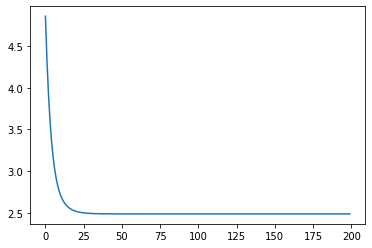

In [247]:
plot_loss(loss_curve)

### Plotting data

As a sanity check, we can also plot the actual data as a histogram alongside our predicted frequencies.
Here, we observe, that our orange line - representing our model - follows the actual data - the histogram - closely

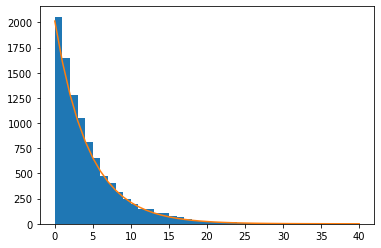

In [248]:
histogram = plt.hist(dataset.numpy(), bins=int(np.max(dataset.numpy())))
arr = []
for i in range(41):
    prob = (1 - model.p()) ** i * model.p()
    arr.append(prob * len(dataset))
plt.plot(list(range(41)), arr)

## Poisson Distribution

Let's try the same thing for the Poisson distribution.

$$\mathcal{L}(D;\lambda) = \prod_{i=1}^{n}\frac{\lambda^{x_i}e^{-\lambda}}{x_i!}$$
$$\log\mathcal{L}(D;\lambda) = \sum_{i=1}^{n}\log\left(\frac{\lambda^{x_i}e^{-\lambda}}{x_i!}\right)$$
$$\log\mathcal{L}(D;\lambda) = \sum_{i=1}^{n}(x_i\log\lambda - \lambda - \log x_{i}!)$$
$$\text{NLL}(D;\lambda) = -\log\mathcal{L}(D;p)$$
$$\text{NLL}(D;\lambda) = -\sum_{i=1}^{n}(x_i\log\lambda - \lambda - \log x_{i}!)$$

Stating this as a minimisation problem and following the same logic from above, we get

$$\min_{\lambda \in \mathbb{R}}\left(-\frac{1}{n}\sum_{i=1}^{n}(x_i\log\lambda - \lambda - \log x_{i}!)\right)$$

The $\log x_{i}!$ is a problem. However, note that it is a constant, i.e. not dependent on $\lambda$. Hence, we can eliminate it from the optimisation problem without consequence! Our problem then becomes:


$$\min_{\lambda \in \mathbb{R}}\left(-\frac{1}{n}\sum_{i=1}^{n}(x_i\log\lambda - \lambda)\right)$$

In [249]:
def loss_function(dataset, lam, eps=0.001):
    p1 = dataset * th.log(lam)
    p2 = -lam
    acc = th.mean(p1 + p2)
    return -acc


# Similarly to p, lam must be positive, so we force it through an absolute function

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        lam_prime = np.random.normal(25)
        self.lam_prime = nn.Parameter(th.tensor(lam_prime))
        
    def lam(self):
        return th.abs(self.lam_prime)
    
        
    
    def loss(self, dataset):
        return loss_function(dataset, self.lam())

In [250]:
model = Model()
lr = 0.1
optimiser = optim.SGD(model.parameters(), lr=lr)
num_iters = 1000
loss_curve = []

In [251]:
fp = open('mle2.npy', 'rb')
dataset = np.load(fp)
fp.close()
dataset = th.tensor(dataset, dtype=th.float32)

In [252]:
for i in range(num_iters):
    optimiser.zero_grad()
    loss_value = model.loss(dataset)
    loss_curve.append(loss_value.data.item())
    loss_value.backward()
    optimiser.step()

In [253]:
lam = model.lam().detach().numpy()
print(lam)

4.995118


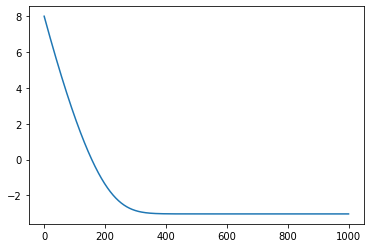

In [254]:
plot_loss(loss_curve)

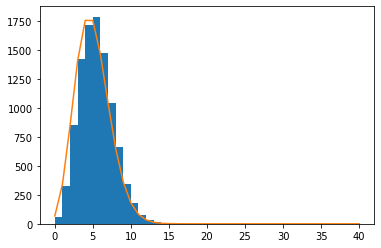

In [255]:
histogram = plt.hist(dataset.numpy(), bins=int(np.max(dataset.numpy())))
arr = []
for i in range(41):
    prob = (lam ** i) * np.exp(-lam)
    prob = prob / np.math.factorial(i)
    arr.append(prob * len(dataset))
plt.plot(list(range(41)), arr)